<a href="https://colab.research.google.com/github/CoolCodeMan/intro2LT/blob/Jenny/keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import sklearn.svm
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np
from keras.models import Model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
import os
import pickle

!wget -nc -O joy-train.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
!wget -nc -O joy-dev.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv
!wget -nc -O joy-test.tsv http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/test.tsv

--2021-04-29 07:36:03--  http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/train.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71887 (70K) [application/octet-stream]
Saving to: ‘joy-train.tsv’

joy-train.tsv       100%[===================>]  70.20K   300KB/s    in 0.2s    

2021-04-29 07:36:04 (300 KB/s) - ‘joy-train.tsv’ saved [71887/71887]

--2021-04-29 07:36:04--  http://dl.turkunlp.org/TKO_8966_2021-projects/joy-annotation/dev.tsv
Resolving dl.turkunlp.org (dl.turkunlp.org)... 195.148.30.23
Connecting to dl.turkunlp.org (dl.turkunlp.org)|195.148.30.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9697 (9.5K) [application/octet-stream]
Saving to: ‘joy-dev.tsv’

joy-dev.tsv         100%[===================>]   9.47K  --.-KB/s    in 0s      

2021-04-29 07:36:04 (160 MB/s) - ‘joy-dev.tsv’ saved [

In [3]:
with open("joy-train.tsv", "r") as f:
  joy_train = pd.read_csv(("joy-train.tsv"), header=0, names=['annotation','text'], sep='\t') # eli tässä luen .tsv-filun ja tallennan sen tuonne joy_trainiin, käyttäen pandas-kirjastoa (importattu as pd)

# tässä voi kattoa miltä nyt näyttää toi joy_train
# print(joy_train[:10])
# print(type(joy_train))

with open("joy-dev.tsv", "r") as f:
  joy_dev = pd.read_csv(("joy-dev.tsv"), header=0, names=['annotation','text'], sep='\t') # sama dev-teksteille

# seuraavaksi luen tekstit ja niiden annotationit omiin listoihinsa molempien (train ja dev) osalta. Tässä vois käyttää tietysti list comprehensionia mut hlökoht pidän tätä "auki kirjoitettua" for-loopia
# helpompana ymmärtää!

train_texts = []
for i in joy_train["text"]:
  train_texts.append(i)
train_labels = []
for i in joy_train["annotation"]:
  train_labels.append(i)

dev_texts = []
for i in joy_dev["text"]:
  dev_texts.append(i)
dev_labels = []
for i in joy_dev["annotation"]:
  dev_labels.append(i)

# tarkistetaan että molemmissa on tekstejä yhtä paljon kuin labeleitä
# assert on nopeampi/lyhyempi tapa tehdä käytännössä if True, continue / if False, raise exception -tyyppinen tarkastus


assert len(train_texts) == len(train_labels)
assert len(dev_texts) == len(dev_labels)

#tässä voi kattella mitä nyt nuo listat pitää sisällään

#for label, text in list(zip(train_labels, train_texts))[:20]:
  #print(label,text)
#for label, text in list(zip(dev_labels, dev_texts))[:20]:
  #print(label,text)

# en näitä nyt shufflaa missään välissä, pitäisikö? luentovideolla perusteltiin datan shufflausta silloin, kun siitä datasta aiotaan erottaa train/dev/test -data (jotta ei käy niin et esim kun ottaa ekat
# 30 % trainiin niin ne on kaikki yhtä luokkaa jne) mutta meillä on tässä valmiiksi erotellut train/dev/test, joten onko tarpeen shufflata?

In [4]:
# laskeskelen tässä, minkä verran train datassa on kumpaakin labelia
not_joys = train_labels.count("not-joy")
joys = len(train_labels)-not_joys
percent_joy = (joys/len(train_labels))*100
percent_not = 100-percent_joy

print(not_joys,joys)
print(percent_not, percent_joy)

543 414
56.739811912225704 43.260188087774296


In [5]:
vectorizer=TfidfVectorizer(binary=True) # määritellään vectorizeriksi sklearnin TfidVectorizer näillä parametreillä. binary=True tekee sen, että kaikki term frequencyt jotka on yli 0 on 1, eli
                                        # ei oteta huomioon sitä, kuinka monta kertaa termi on dokumentissa, vaan sillä on väliä, onko se vai eikö se ole -> eli binäärinen systeemi.

# sitten tehdään sekä train että dev teksteistä omat feature matrixit käyttäen tätä vectorizeria (featureiden ollessa nyt siis käytännössä sanoja).
# train-teksteihin käytetään fit_transformia, jonka avulla vectorizer oppii sanaston ja idf:t ja palauttaa document-term matriisin.
# koska train-tekstien avulla on tehty jo fit eli opetus, deviin riittää pelkkä transform (joka palauttaa document-term matriisin)

feature_matrix_train=vectorizer.fit_transform(train_texts)
feature_matrix_dev=vectorizer.transform(dev_texts)

In [6]:
# sitten ois vuorossa NN-based BoW classifier

# keras ei hyväksy numpy matriiseja, joten ne pitää muuttaa tensor-matriiseiksi, luennolla opet selitti löytäneensä
# ja kopioineensa tän stack overflowsta ja hyvin näyttää toimivan

def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))

feature_matrix_train_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_train)
feature_matrix_dev_tf=convert_sparse_matrix_to_sparse_tensor(feature_matrix_dev)

In [7]:
# sitten muutetaan labelit numeroiksi label_encoderin avulla. Ensin train labeleihin fit_transform joka sovittaa labelit numeoriksi ja palauttaa muutetut,
# dev-labeleille ei tarvitse taas fittiä enää tehdä vaan transform riittää

label_encoder=LabelEncoder() 
class_numbers_train=label_encoder.fit_transform(train_labels)
class_numbers_dev=label_encoder.transform(dev_labels)

print("class_numbers shape=",class_numbers_train.shape)
print("class labels",label_encoder.classes_) #this will let us translate back from indices to labels

class_numbers shape= (957,)
class labels ['joy' 'not-joy']


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras import initializers
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.activations import softmax

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", \
                                        mode ="min", patience = 5, \
                                        restore_best_weights = True)

example_count,feature_count=feature_matrix_train.shape
example_count2=class_numbers_train.shape[0]
assert example_count==example_count2  # sanity check

class_count=len(label_encoder.classes_) # luokkien määrä, tässä vois olla kaksi, mutta näin voidaan käyttää samaa koodia muuallakin

# rakennetaan neuraaliverkko:

inp=Input(shape=(feature_count,)) 
hidden=Dense(1500, bias_regularizer=l2(0.0000001), activation="tanh")(inp) 
hidden2=Dropout(0.8)(hidden)
hidden3=Dense(1500, bias_regularizer=l2(0.0000001), activation="relu")(hidden2)
hidden4=Dropout(0.5)(hidden3)
outp=Dense(class_count,activation='sigmoid')(hidden4) #softplus #softmax #sigmoid

model=Model(inputs=[inp], outputs=[outp])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss="sparse_categorical_crossentropy", metrics="accuracy")

hist=model.fit(feature_matrix_train_tf,class_numbers_train,\
               validation_data=(feature_matrix_dev_tf,class_numbers_dev), callbacks = [earlystopping], \
               batch_size=8,verbose=1,epochs=1000)



Epoch 1/1000
120/120 [==============================] - 5s 42ms/step - loss: 0.6825 - accuracy: 0.5354 - val_loss: 0.5624 - val_accuracy: 0.7153
Epoch 2/1000
120/120 [==============================] - 5s 39ms/step - loss: 0.4398 - accuracy: 0.8542 - val_loss: 0.5836 - val_accuracy: 0.7569
Epoch 3/1000
120/120 [==============================] - 5s 39ms/step - loss: 0.1548 - accuracy: 0.9437 - val_loss: 0.7247 - val_accuracy: 0.7639
Epoch 4/1000
120/120 [==============================] - 5s 39ms/step - loss: 0.0638 - accuracy: 0.9815 - val_loss: 0.7940 - val_accuracy: 0.7986
Epoch 5/1000
120/120 [==============================] - 5s 39ms/step - loss: 0.0103 - accuracy: 0.9985 - val_loss: 0.9072 - val_accuracy: 0.8056
Epoch 6/1000
120/120 [==============================] - 5s 39ms/step - loss: 0.0120 - accuracy: 0.9974 - val_loss: 0.9425 - val_accuracy: 0.8056


In [ ]:
print(hist.history["val_accuracy"])

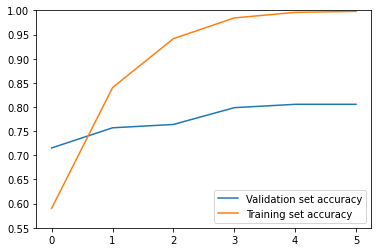

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.ylim(0.55,1.0)
plt.plot(hist.history["val_accuracy"],label="Validation set accuracy")
plt.plot(hist.history["accuracy"],label="Training set accuracy")
plt.legend()
plt.show()